In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

#Sampling methods
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#feature engineering
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from boruta import BorutaPy

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

# Importing

In [2]:
train = pd.read_csv(r"C:\Users\ASUS\Desktop\cs\Credit card Fraud Detection\fraudTrain.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

# Data Cleansing

In [3]:
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0


In [4]:
train.shape

(1296675, 22)

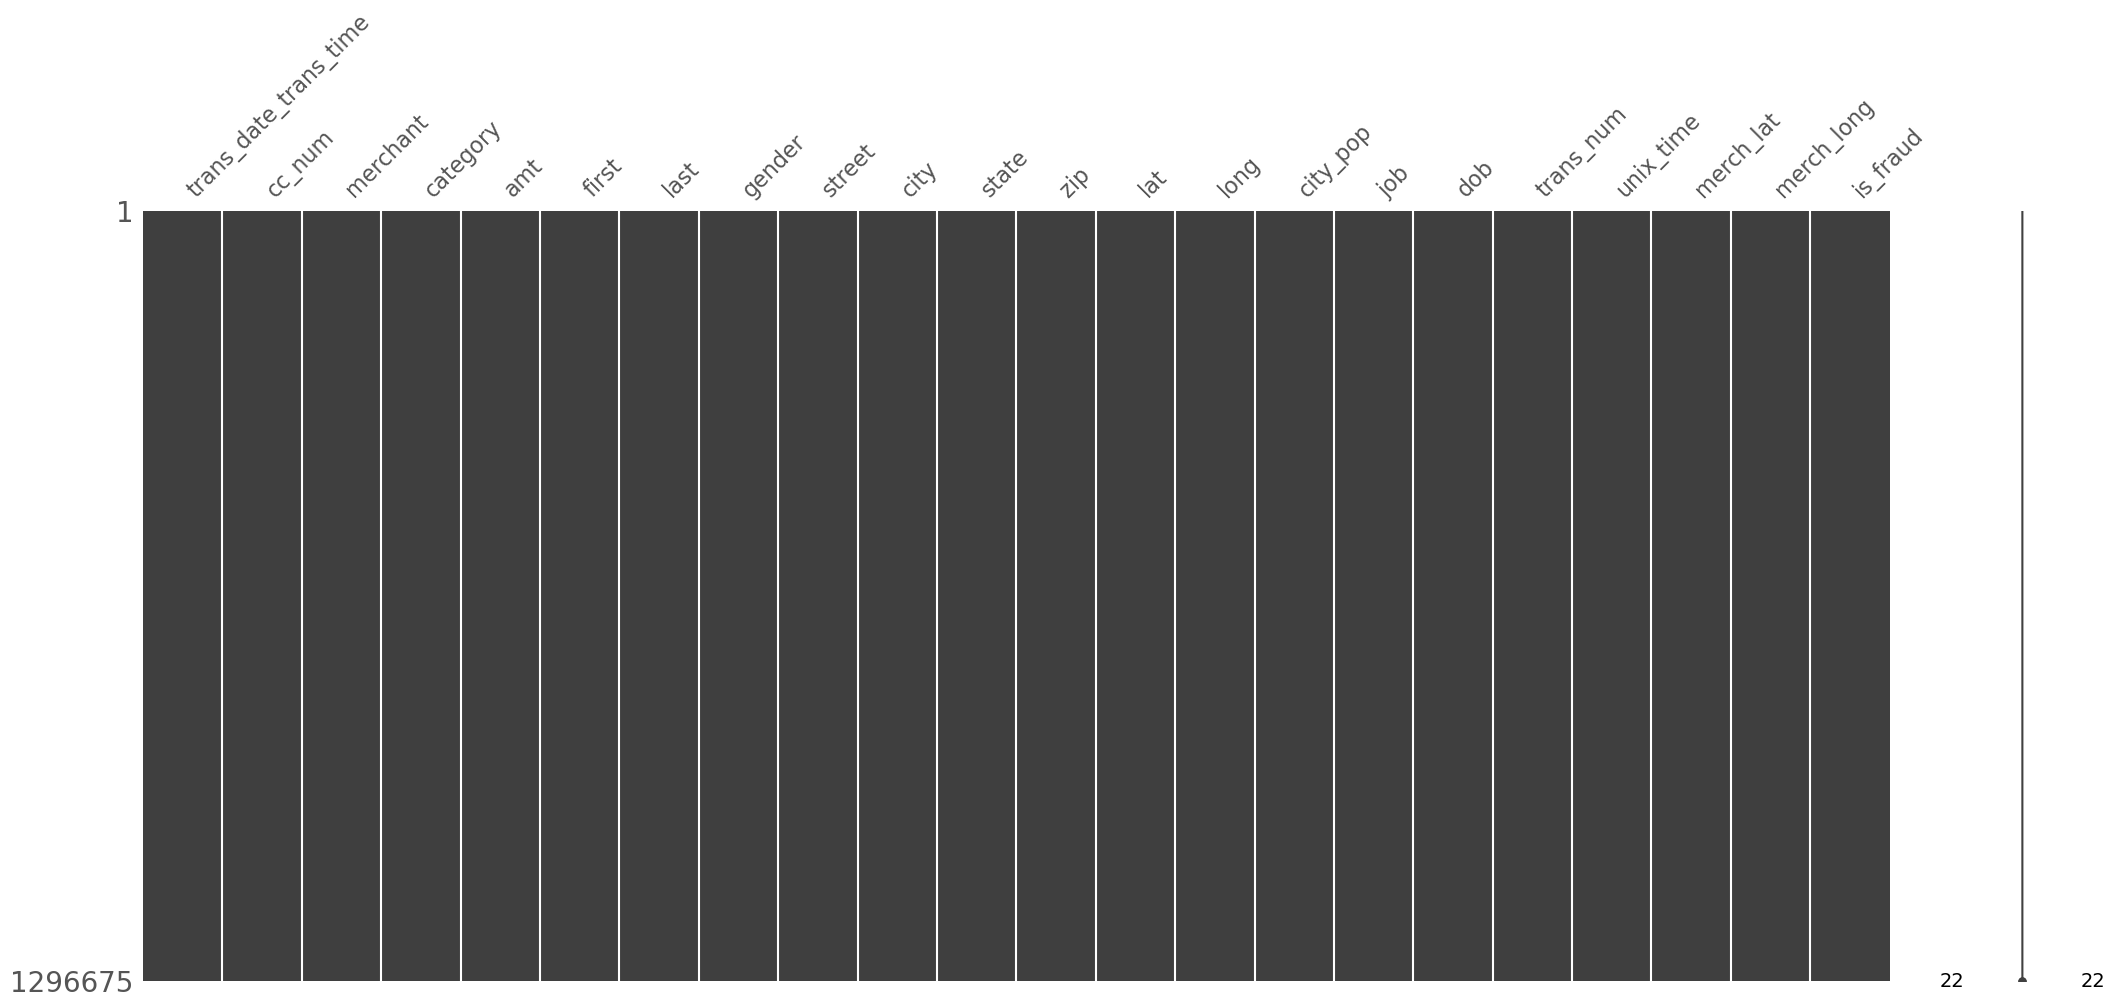

In [5]:
msno.matrix(train);


In [6]:
train.isna().sum()
#no missing Values here 

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Exploratory Data Analysis (EDA)

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,789,248.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95
is_fraud,"1,296,675.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


In [8]:
train["amt"].describe()


count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

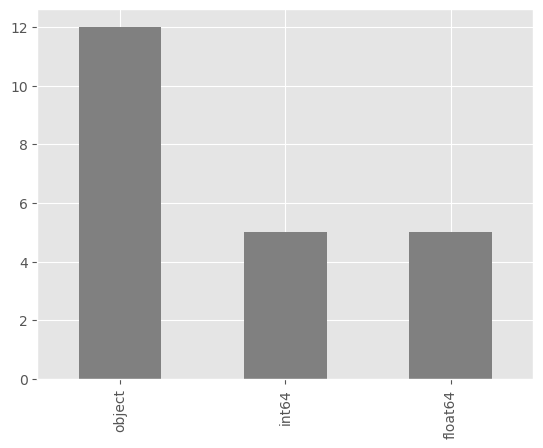

In [9]:
train.dtypes.value_counts().plot(kind='bar', color="grey");


# Univariate analysis

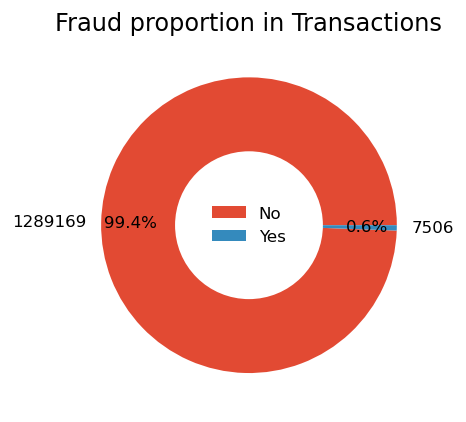

In [10]:
donut = train["is_fraud"].value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show();

We Have A severe imbalance in Data

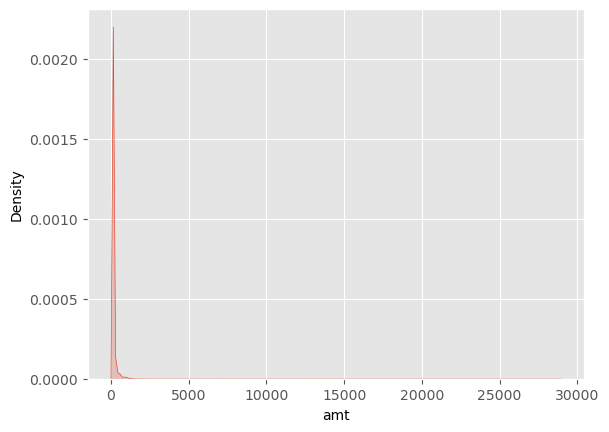

In [11]:
sns.kdeplot(train["amt"], fill=True);


Higher values of amount is distorting the graph. So we fix it plotting only 0-99% of amount

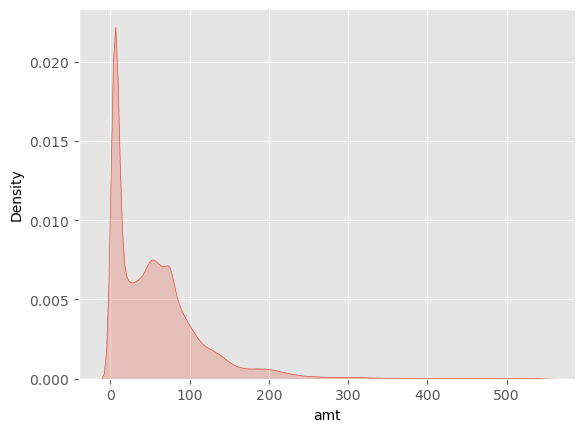

In [12]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);


# Multivariate analysis

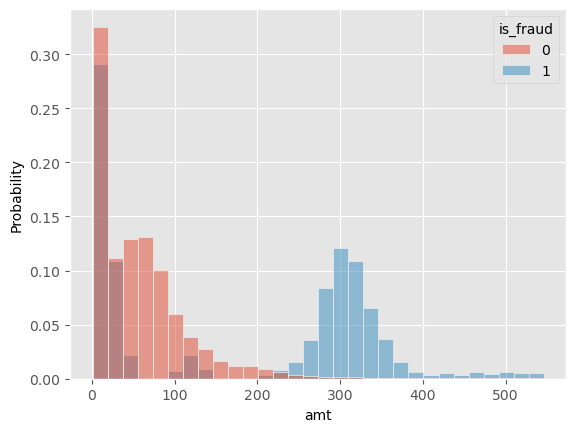

In [13]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= p99],
             common_norm=False);

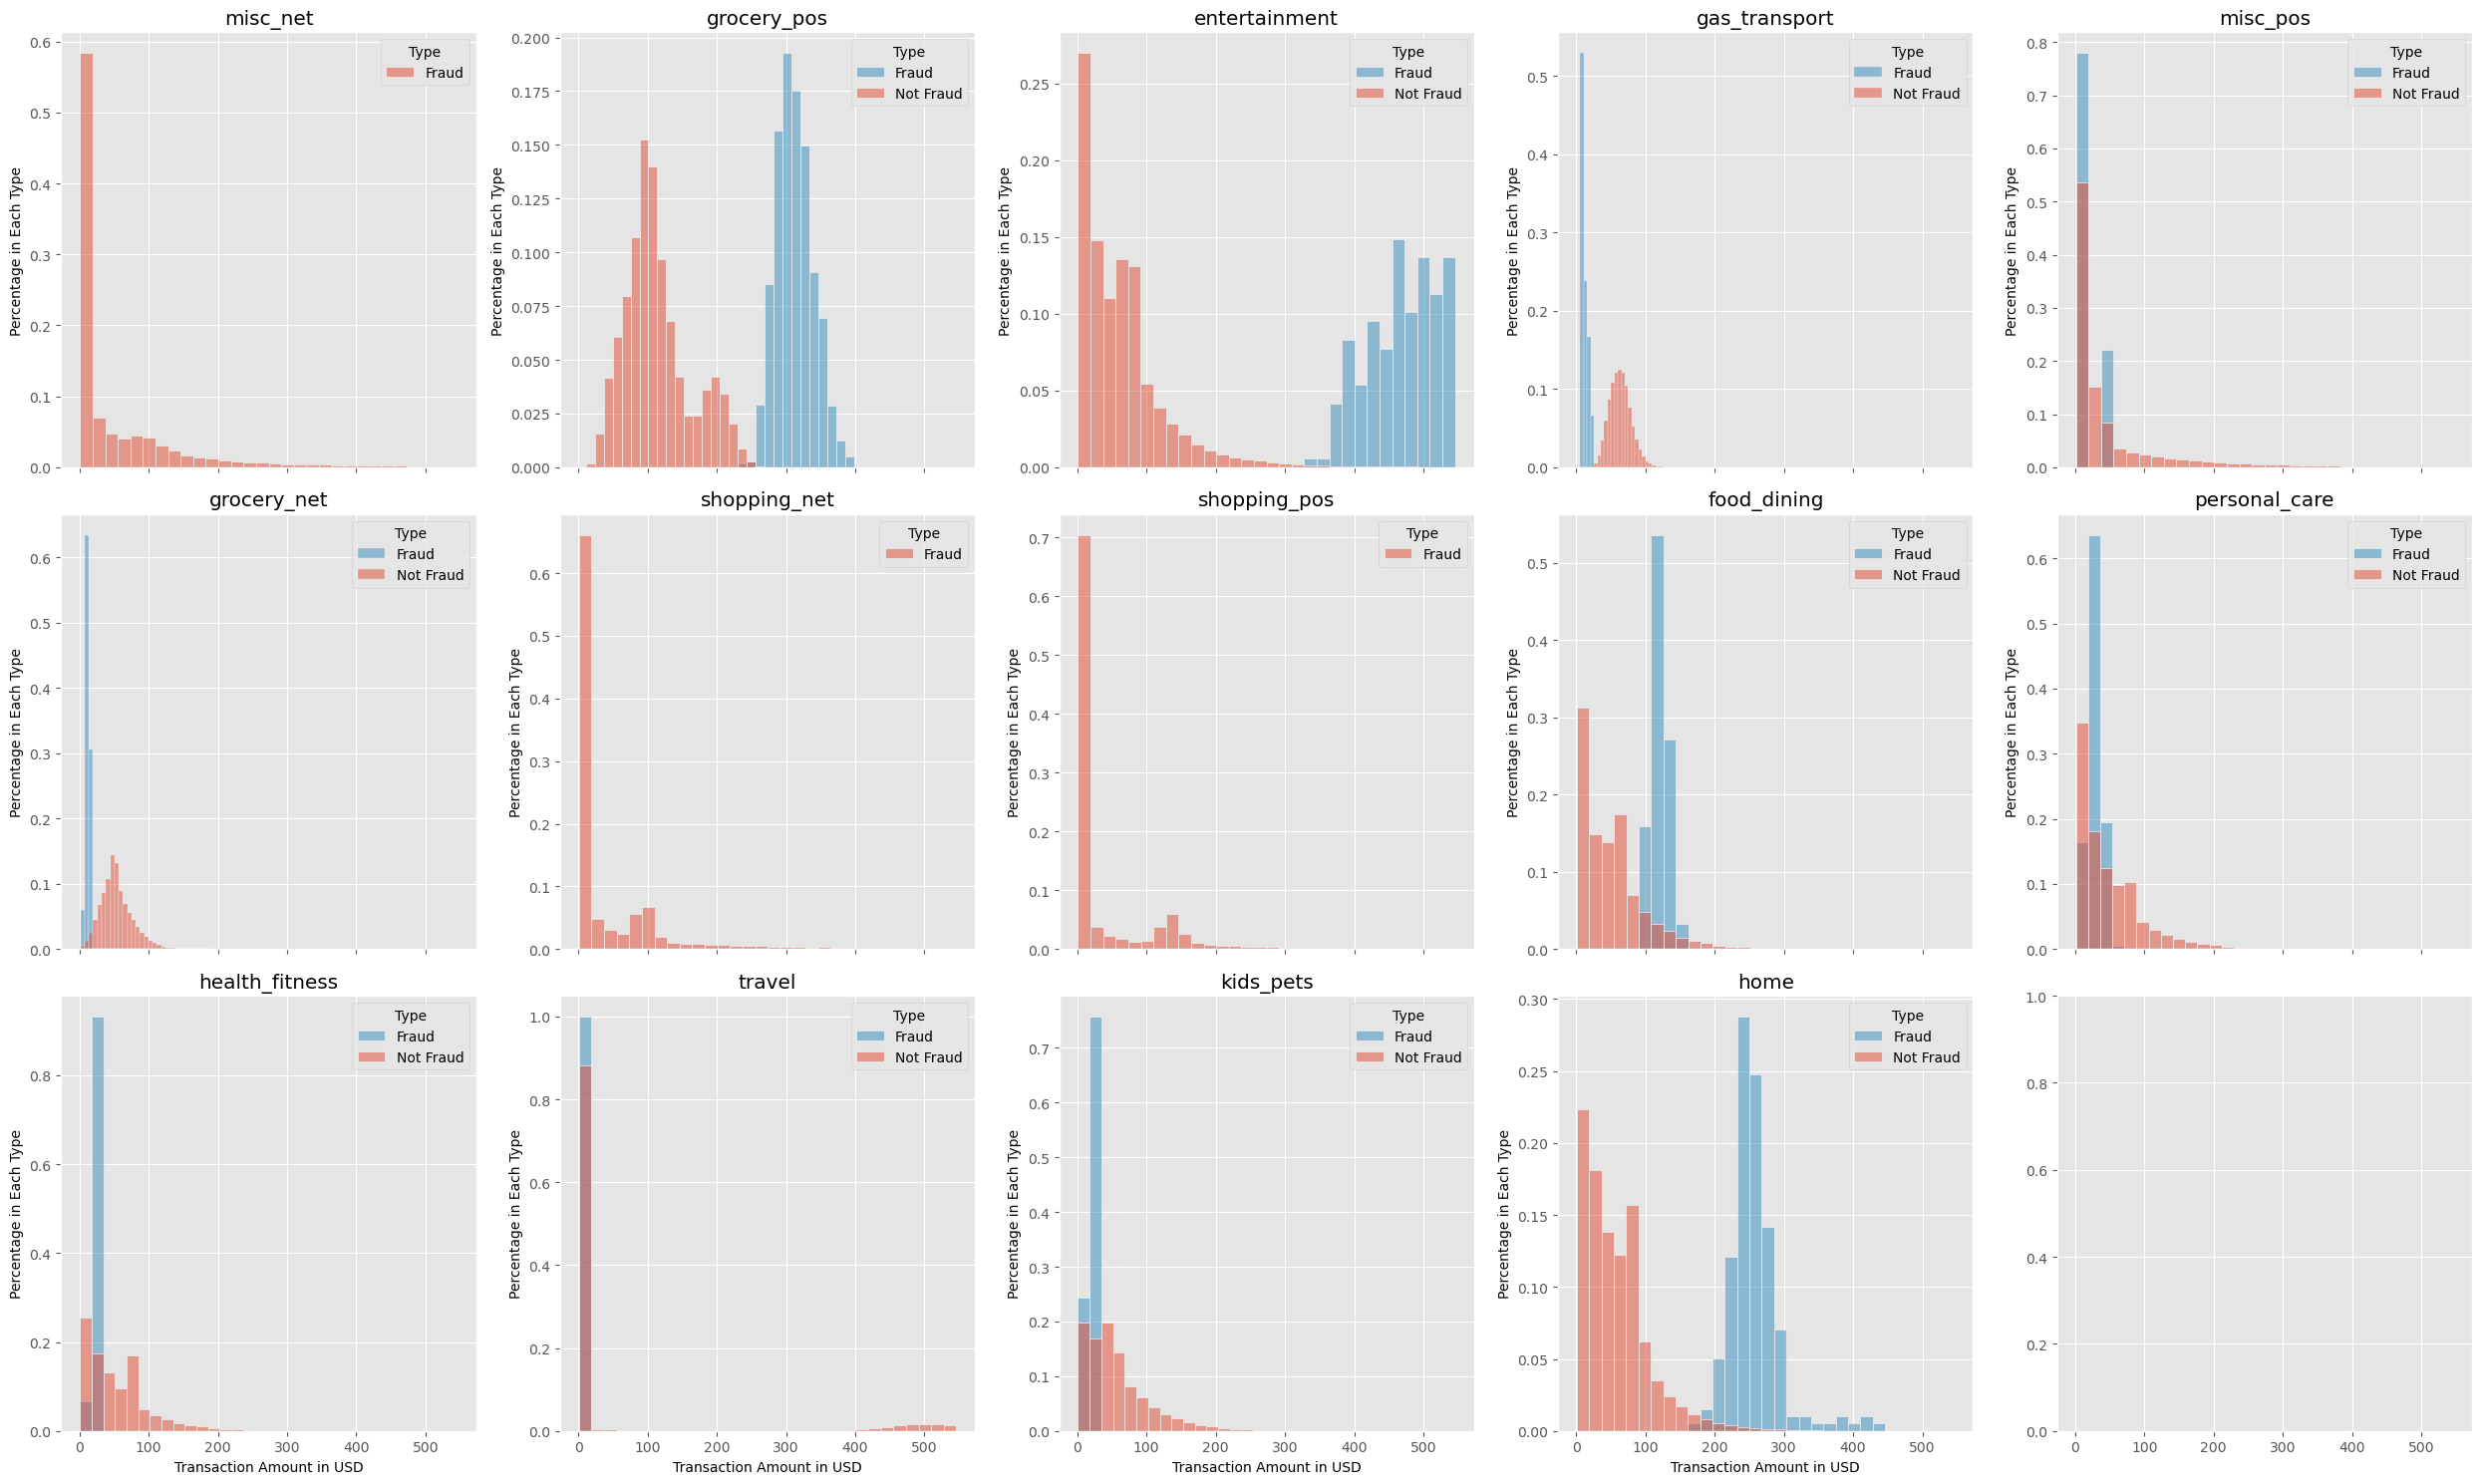

In [14]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

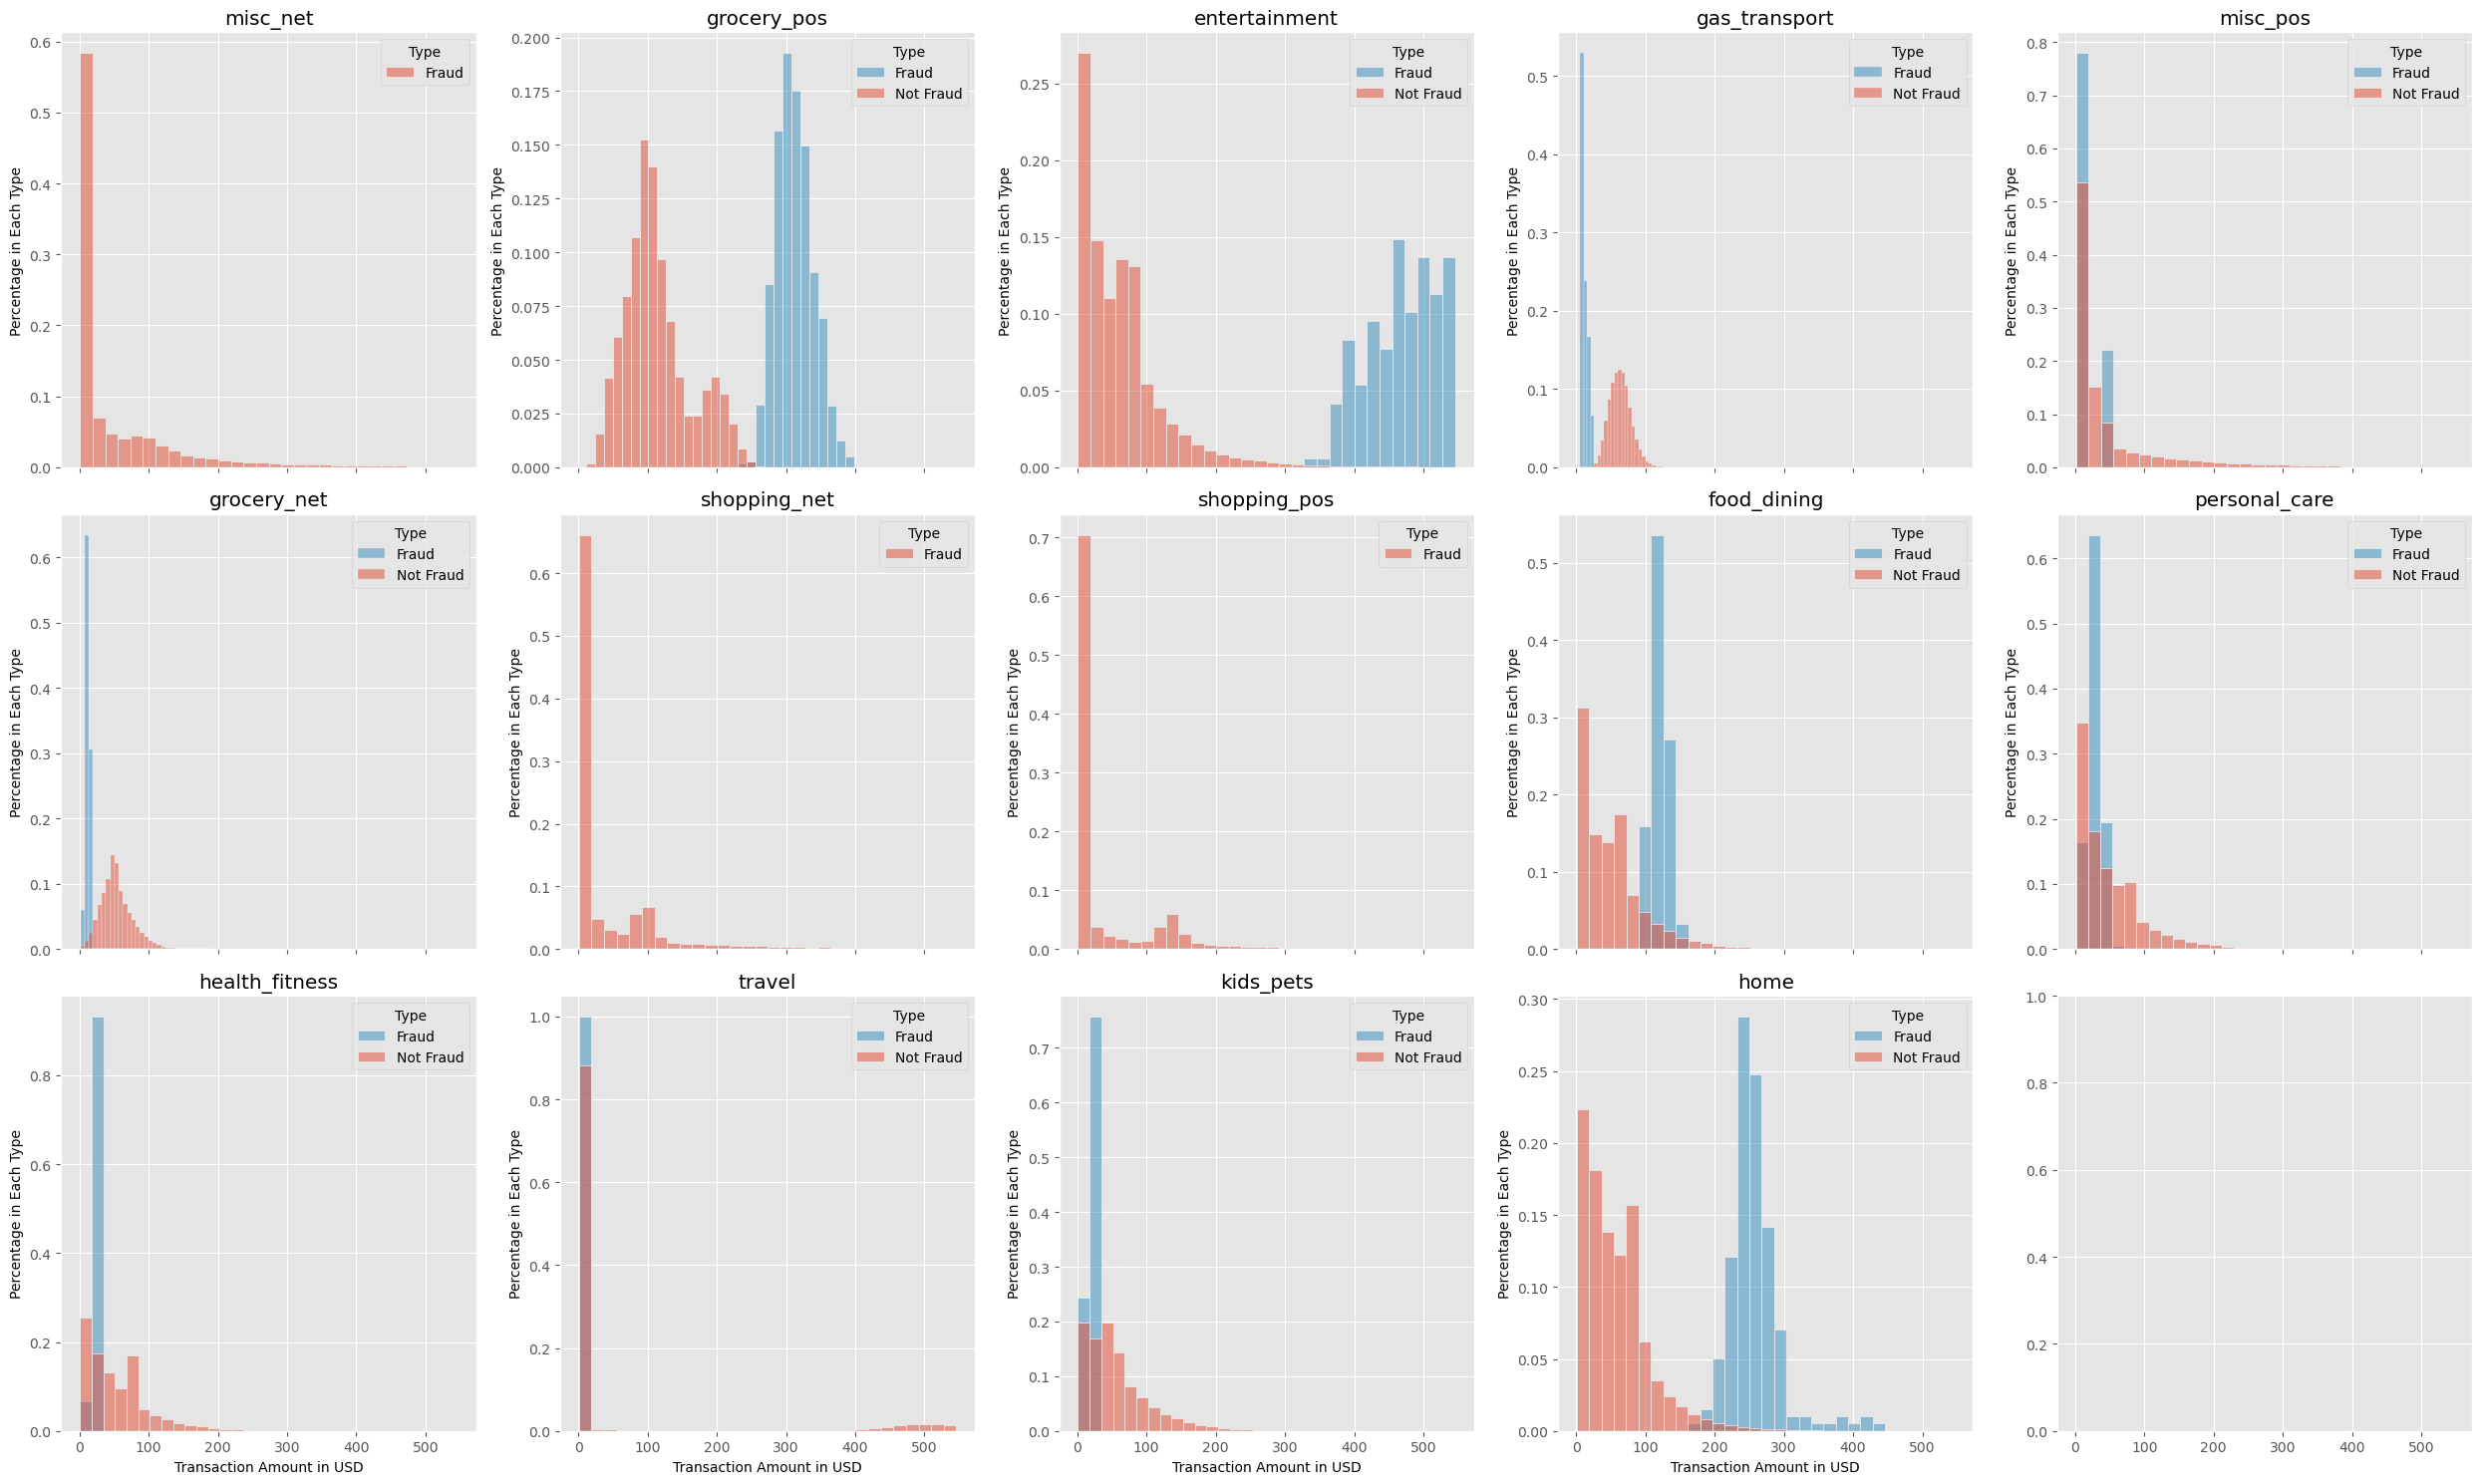

In [15]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

In [16]:
# non_fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.08,-0.02
1,home,0.10,0.03,-0.07
2,grocery_pos,0.09,0.23,0.14
3,shopping_pos,0.09,0.11,0.02
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.23,0.15
6,entertainment,0.07,0.03,-0.04
7,food_dining,0.07,0.02,-0.05
8,personal_care,0.07,0.03,-0.04
9,health_fitness,0.07,0.02,-0.05


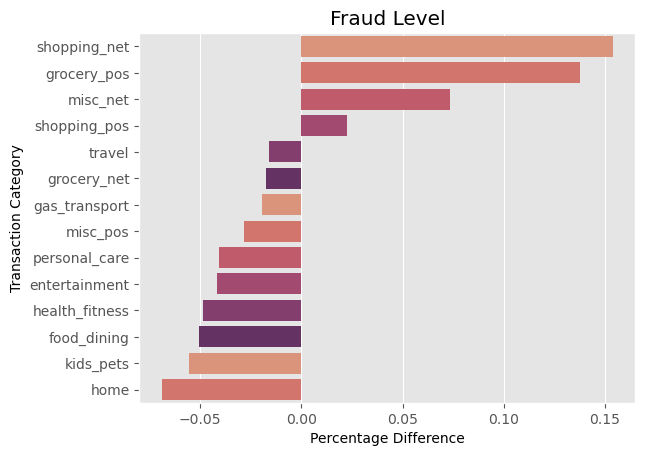

In [17]:
custom_palette = sns.color_palette("flare")
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

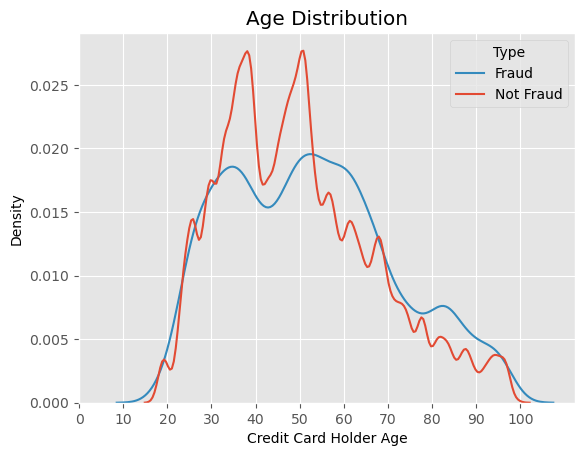

In [18]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

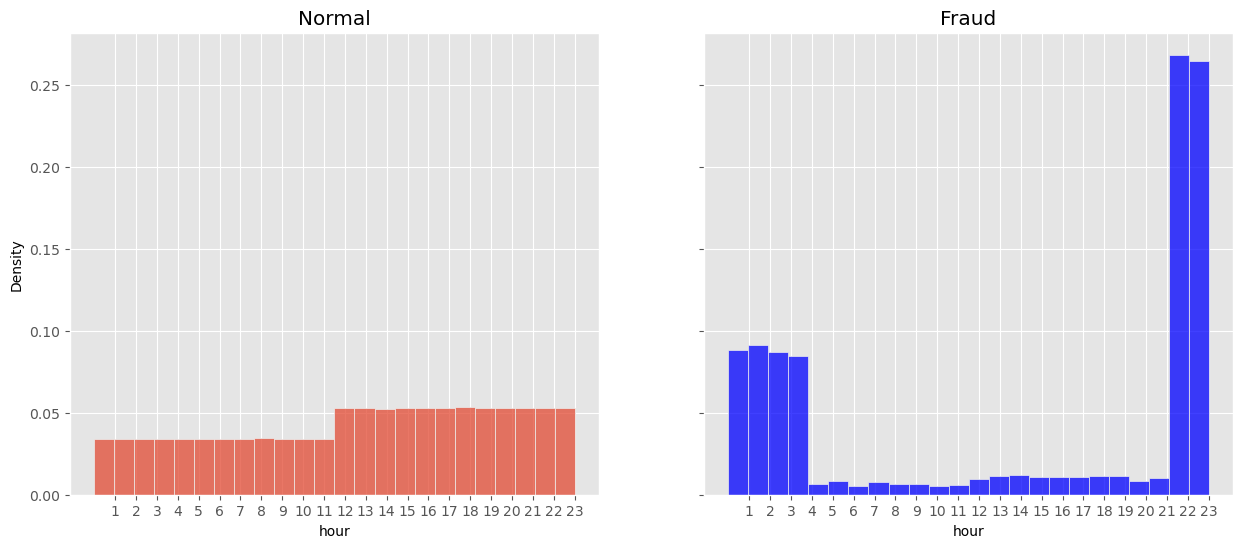

In [19]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

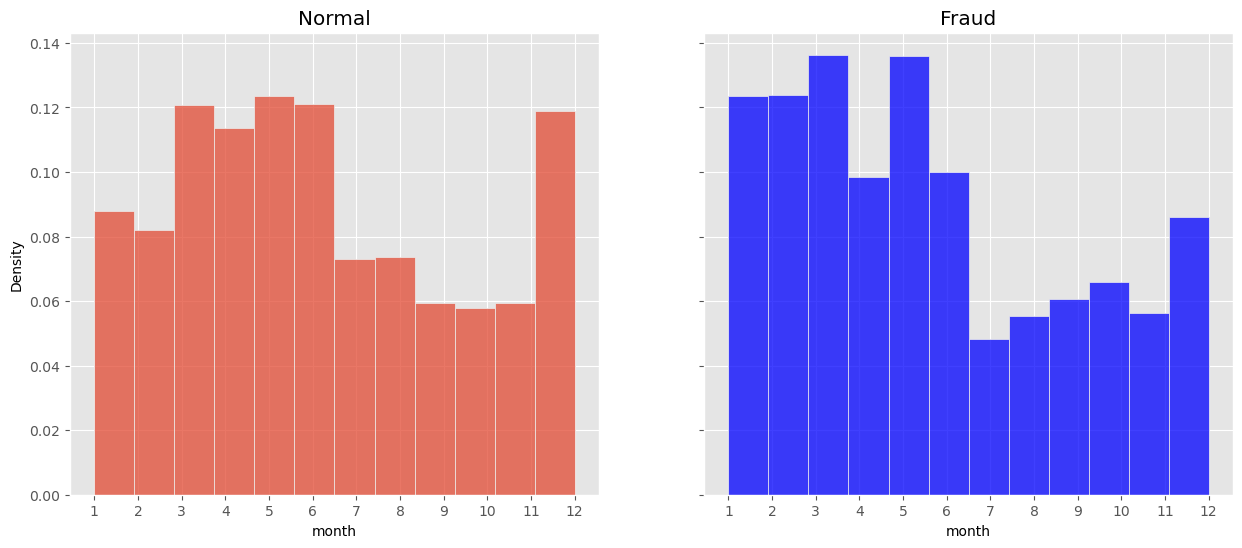

In [20]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

# Feature Engineering


In [21]:
train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [22]:
train.head(2)


,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,35,0,1
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,45,0,1


## Scaling

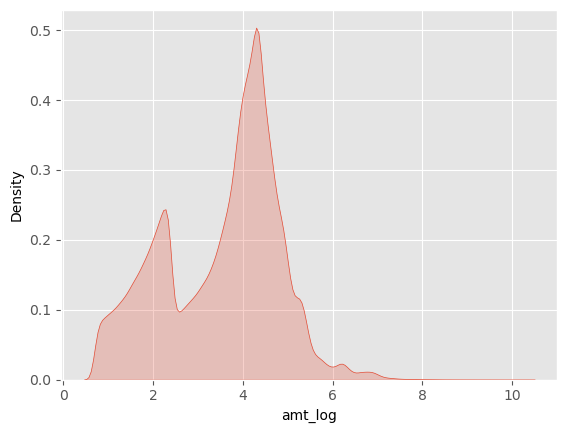

In [23]:
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True);


In [24]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


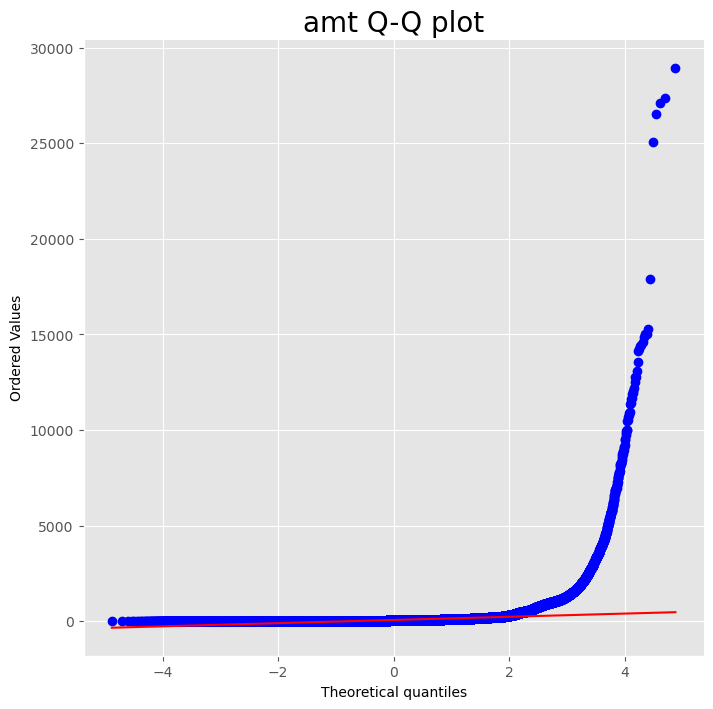

In [25]:
check_normality("amt");


amt_log : mean: 3.53, std: 1.29, skew: -0.30


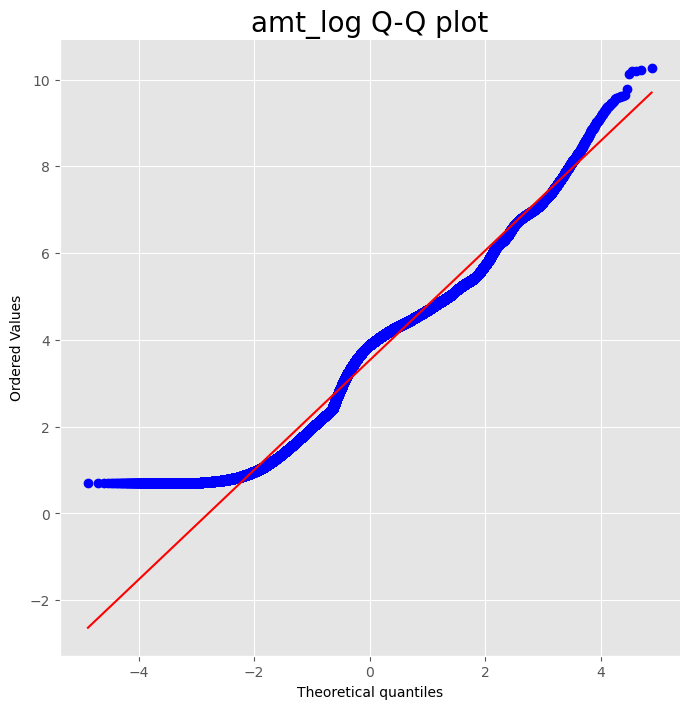

In [26]:
check_normality("amt_log");


## Categorical Encoding

In [27]:
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = train[col]
        y = train[target_col]

        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)

    return train


columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

train = apply_woe(train, columns_to_encode, target_column)

In [28]:
gender_mapping = {"F": 0, "M": 1}

train["gender_binary"] = train["gender"].map(gender_mapping)

In [29]:
freq_enc = (train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
train["cc_num_frequency"] = train["cc_num"].apply(lambda x: freq_enc[x])

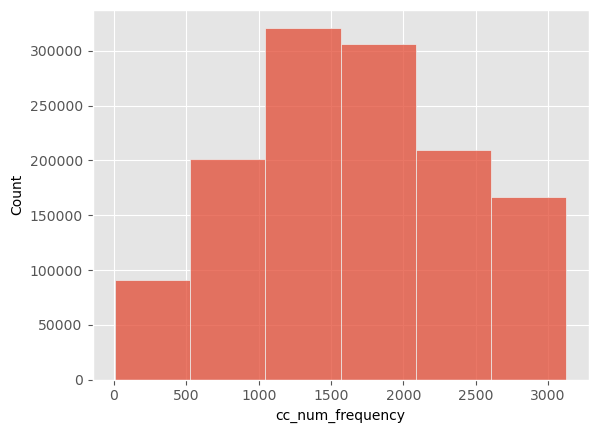

In [30]:
sns.histplot(train["cc_num_frequency"], bins=6);

In [31]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


train["cc_num_frequency_classification"] = train["cc_num_frequency"].apply(
    classify_frequency)

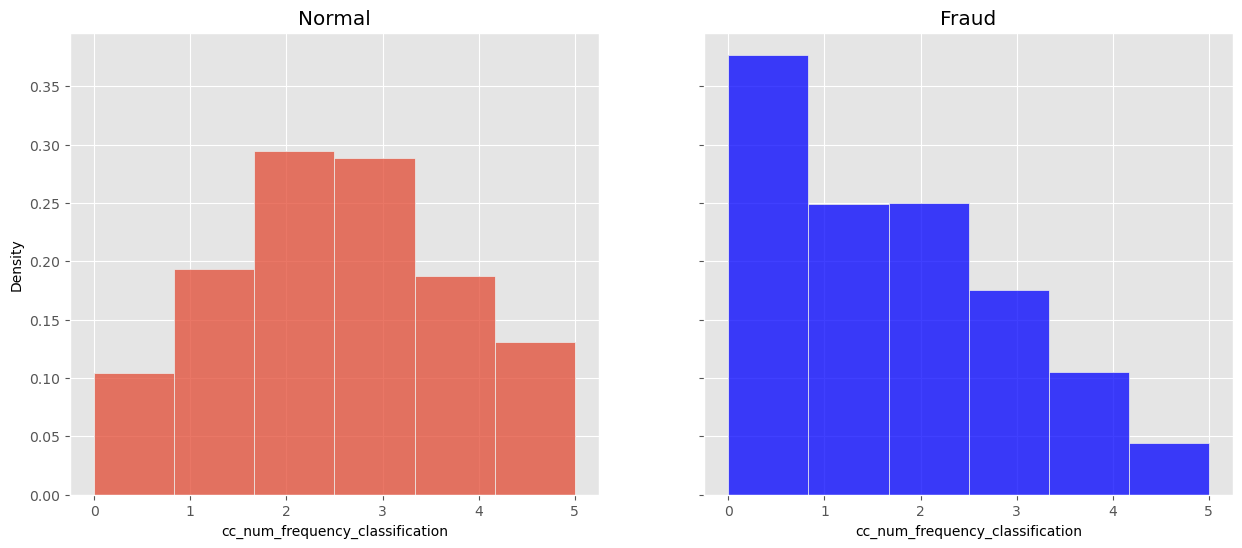

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1)
ax2 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud");

# Undersampling

In [33]:
X = train.drop(columns=["is_fraud"])
y = train["is_fraud"]

In [34]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)


In [35]:
X_undersampled, y_undersampled = rus.fit_resample(X, y)


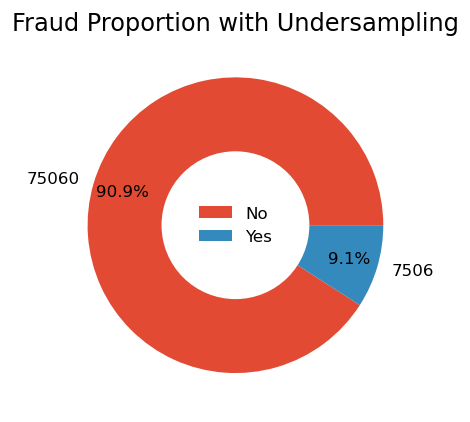

In [36]:
donut = y_undersampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();


# Feature Importance

In [37]:
X_undersampled["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_undersampled))
X_undersampled["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_undersampled))


In [38]:
X_train = X_undersampled.drop(columns=["trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])

y_train = y_undersampled

In [39]:
X_train.head()

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification,random_feat_1,random_feat_2
0,77566,29.04,-95.44,28739,29.24,-95.43,24,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4,56,130
1,12460,42.41,-74.15,277,41.56,-74.09,52,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2,52,14
2,98304,46.75,-121.99,759,46.60,-122.18,67,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1,62,136
3,31042,32.81,-83.17,1841,33.09,-84.14,48,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2,43,254
4,99160,48.89,-118.21,149,48.08,-119.14,45,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5,48,204


In [40]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)

Features selected:


['zip',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'hour',
 'month',
 'amt_log',
 'category_WOE',
 'state_WOE',
 'city_WOE',
 'job_WOE',
 'gender_binary',
 'cc_num_frequency',
 'cc_num_frequency_classification']

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_


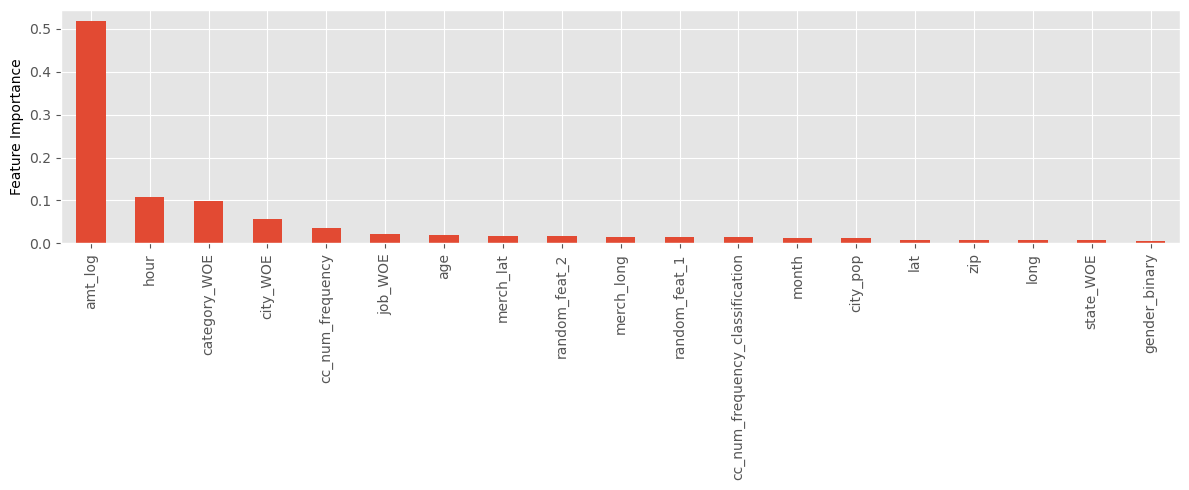

In [42]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

In [43]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                      "city_pop", "month", "cc_num_frequency_classification",
                      "random_feat_1", "random_feat_2", "merch_long"], inplace=True)

In [44]:
X_train.head()

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,29.24,24,5,3.89,-0.21,0.14,0.35,2556
1,41.56,52,7,4.65,0.90,0.20,0.70,1548
2,46.60,67,18,2.39,-0.70,0.77,0.11,1040
3,33.09,48,5,3.63,-0.61,0.00,-0.23,1548
4,48.08,45,23,1.42,1.12,-3.03,-0.90,3030


Finally, this is the features that are entering the model.

## Preparing test data

In [45]:
test = pd.read_csv(r"C:\Users\ASUS\Desktop\cs\Credit card Fraud Detection\fraudTest.csv", index_col=0)

test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)

test["amt_log"] = np.log1p(test["amt"])

test = apply_woe(test, columns_to_encode, target_column)

test["gender_binary"] = test["gender"].map(gender_mapping)

freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(
    classify_frequency)

X_test = test.drop(columns=["trans_date_trans_time",
                            "city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])

y_test = test["is_fraud"]

X_test.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                     "city_pop", "month", "cc_num_frequency_classification", "merch_long"], inplace=True)

# Preparing validation data

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2)

# Training the model

In [47]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None


In [48]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
lgbm = LGBMClassifier(random_state=23)


In [49]:
print("Feature names in X_train:", X_train.columns.tolist())
print("Feature names in X_test:", X_test.columns.tolist())


Feature names in X_train: ['merch_lat', 'age', 'hour', 'amt_log', 'category_WOE', 'city_WOE', 'job_WOE', 'cc_num_frequency']
Feature names in X_test: ['merch_lat', 'age', 'hour', 'amt_log', 'category_WOE', 'city_WOE', 'job_WOE', 'cc_num_frequency']


In [50]:
#random forest

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]

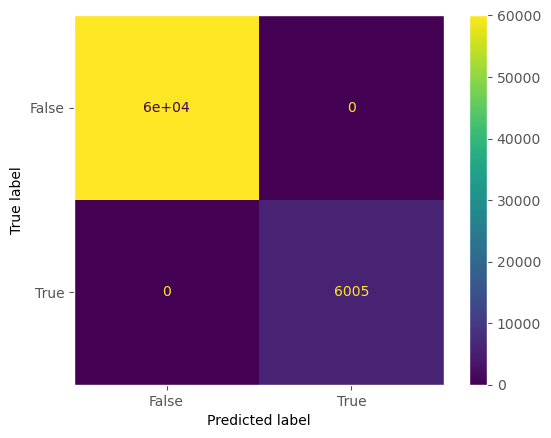

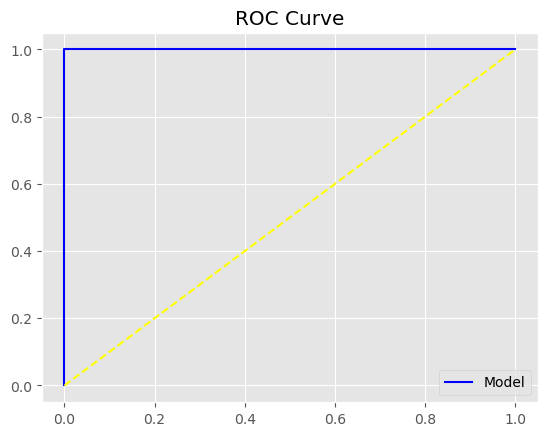

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [51]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

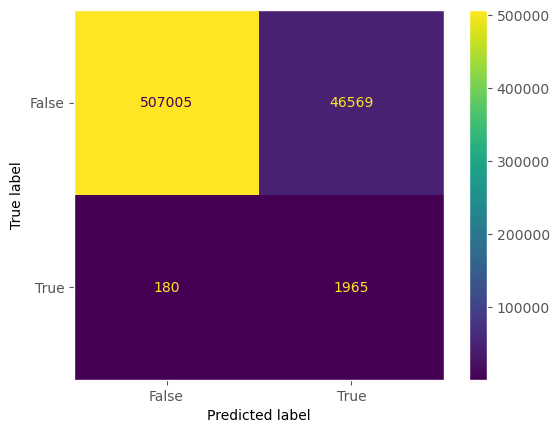

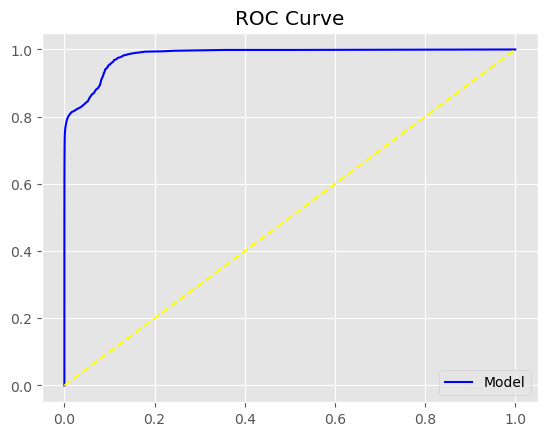

Accuracy 0.92
Precision: 0.04
Recall: 0.92
F1 Score 0.08
AUC: 0.9828725340902575


In [52]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)


In [53]:
#k-nearest neighbors

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]

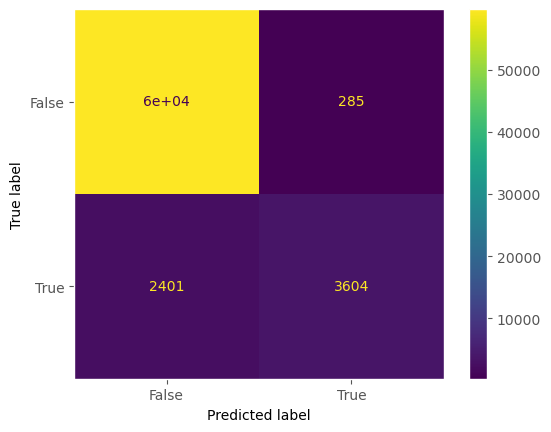

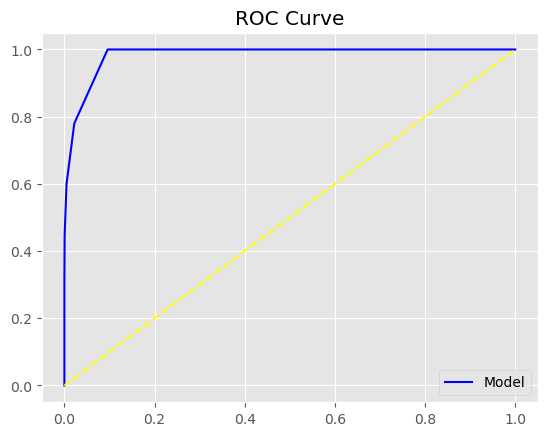

Accuracy 0.96
Precision: 0.93
Recall: 0.6
F1 Score 0.73
AUC: 0.9841856615592834


In [54]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

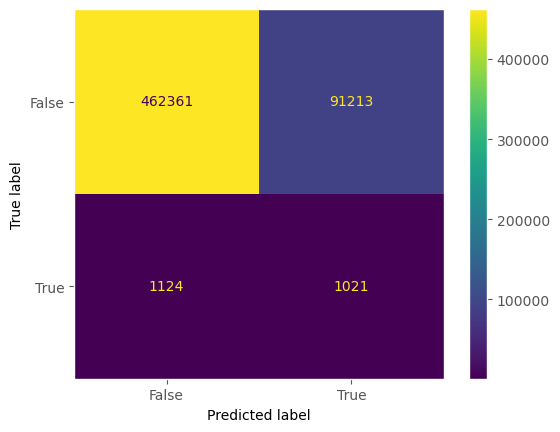

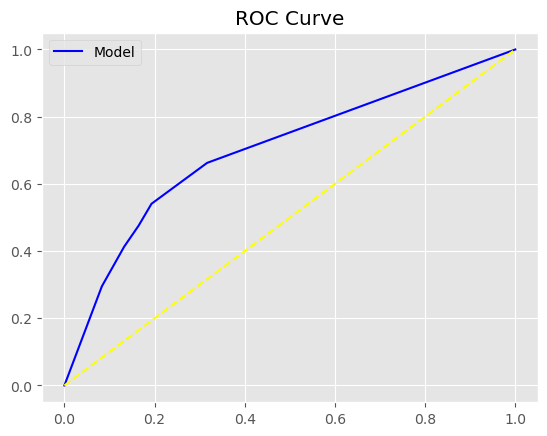

Accuracy 0.83
Precision: 0.01
Recall: 0.48
F1 Score 0.02
AUC: 0.7008879232684903


In [55]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [56]:
#gradient boosting

gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]

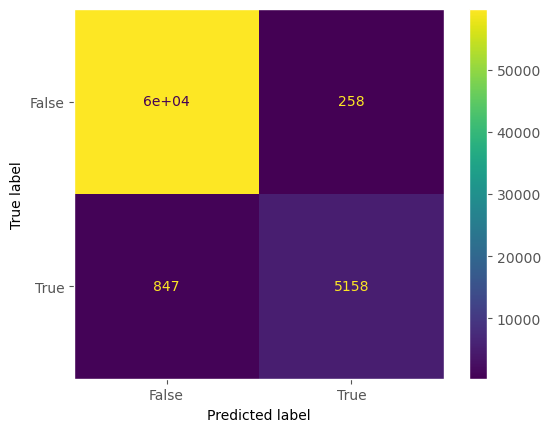

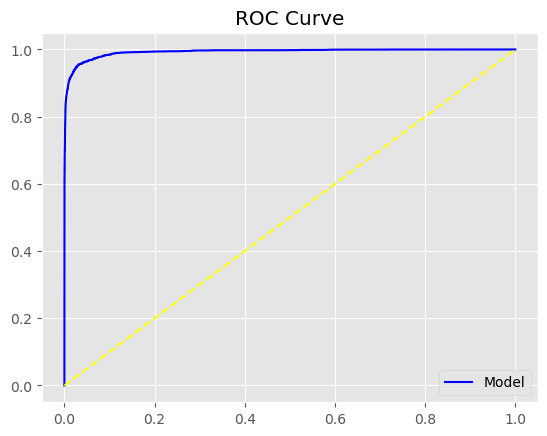

Accuracy 0.98
Precision: 0.95
Recall: 0.86
F1 Score 0.9
AUC: 0.9929550980236174


In [57]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)


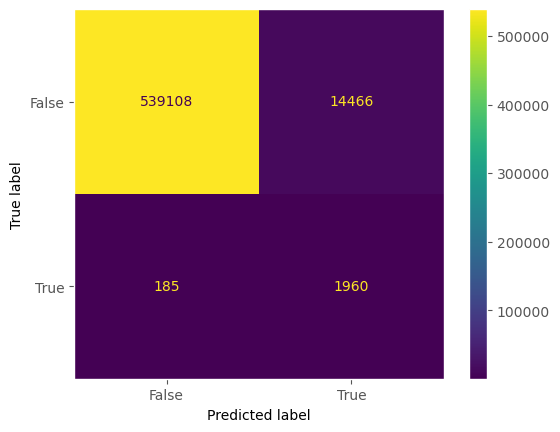

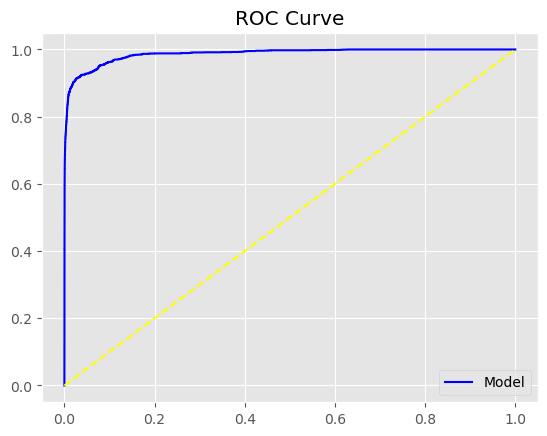

Accuracy 0.97
Precision: 0.12
Recall: 0.91
F1 Score 0.21
AUC: 0.9869110551908155


In [58]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)


In [59]:
#LightGBM

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


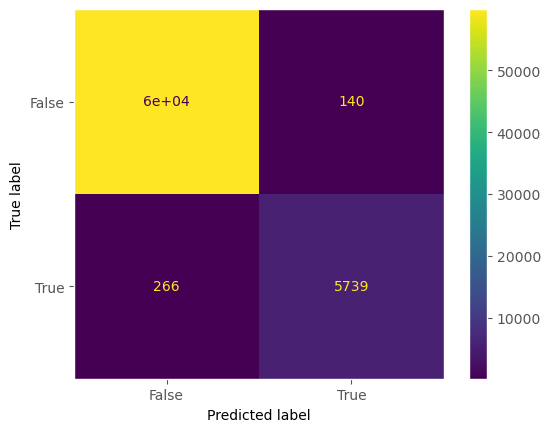

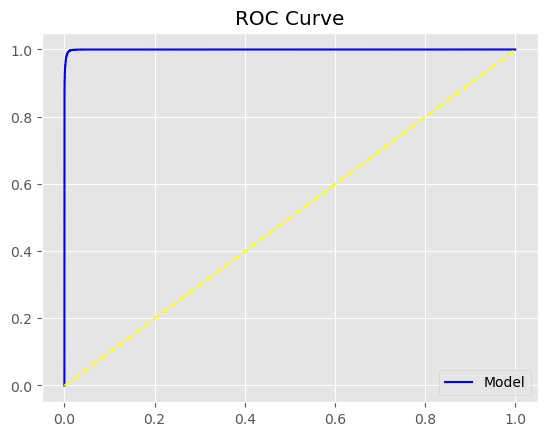

Accuracy 0.99
Precision: 0.98
Recall: 0.96
F1 Score 0.97
AUC: 0.9996635413832853


In [60]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

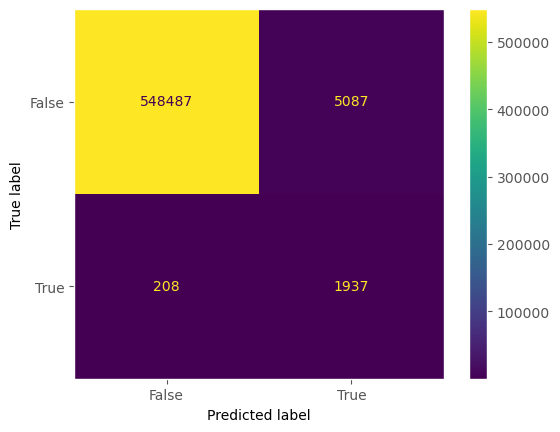

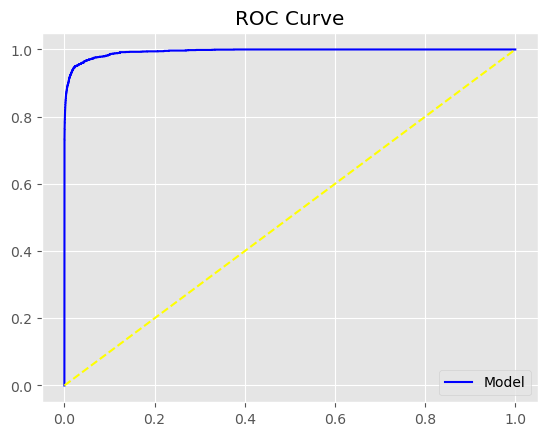

Accuracy 0.99
Precision: 0.28
Recall: 0.9
F1 Score 0.42
AUC: 0.9942329430683291


In [61]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

# Hyperparameter Tuning

In [62]:
def tune_lgbm(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    mdl = LGBMClassifier(learning_rate= learning_rate,
                         num_leaves= num_leaves,
                         min_child_samples= min_child_samples,
                         subsample= subsample,
                         colsample_bytree= colsample_bytree,
                         random_state=23, subsample_freq=1,
                         n_estimators=200)
    
    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_valid)
    
    return -metrics.f1_score(y_valid, y_pred)

In [63]:
space = [(1e-3, 1e-1, "log-uniform"), #learning_rate
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05, 1.0), #subsample
        (0.1, 1.0)] #colsample_bytree

In [64]:
results = gp_minimize(tune_lgbm, space, random_state=23,
                      verbose=1, n_calls=100, n_random_starts=20)

Iteration No: 1 started. Evaluating function at random point.
[0.021786840314037433, 25, 78, 0.5952129636704409, 0.4977223159193984]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4111
Function value obtained: -0.9074
Current minimum: -0.9074
Iteration No: 2 started. Evaluating function at random point.
[0.002333405878539521, 15, 23, 0.8416721432755412, 0.4840888306663812]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wis

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.4167
Function value obtained: -0.8821
Current minimum: -0.9447
Iteration No: 12 started. Evaluating function at random point.
[0.03486657777966428, 100, 97, 0.44192276574439365, 0.8162320161324087]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.8943
Function value obtained: -0.9455
Current minimum: -0.9455
Iteration No: 13 started. Eval

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.0681
Function value obtained: -0.5497
Current minimum: -0.9494
Iteration No: 23 started. Searching for the next optimal point.
[0.026032156616942175, 119, 96, 0.602573959291001, 0.893475575352263]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.4480
Function value obtained: -0.9411
Current minimum: -0.9494
Iteration

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.4058
Function value obtained: -0.9428
Current minimum: -0.9494
Iteration No: 34 started. Searching for the next optimal point.
[0.04858792358820441, 128, 100, 1.0, 0.1]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.2561
Function value obtained: -0.9434
Current minimum: -0.9494
Iteration No: 38 started. Searching for the next optimal point.
[0.040767065844179426, 2, 1, 1.0, 1.0]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.7467
Function value obtained: -0.7988
Current minimum: -0.9494
Iteration No: 39 started. Searching for the next optimal point.
[0.029619790298017024, 128, 39, 1.0, 0.928802434451

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.0799
Function value obtained: -0.8503
Current minimum: -0.9515
Iteration No: 45 started. Searching for the next optimal point.
[0.010980284163456106, 128, 1, 0.9376956218949188, 0.9527588715151766]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.3247
Function value obtained: -0.9433
Current minimum: -0.9515
Iteration No: 46 started. Searching for the next optimal point.
[0.0390502407308413

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.3020
Function value obtained: -0.9114
Current minimum: -0.9521
Iteration No: 53 started. Searching for the next optimal point.
[0.03493918766978636, 128, 100, 1.0, 0.7924116552794419]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.3016
Function value obtained: -0.9457
Current minimum: -0.9521
Iteration No: 54 started. Searching for the next optimal point.
[0.1, 128, 100, 1.0, 0.1]
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 1.2078
Function value obtained: -0.8323
Current minimum: -0.9527
Iteration No: 57 started. Searching for the next optimal point.
[0.009455998154235569, 85, 1, 0.7375759454700088, 0.8164772002442859]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.2079
Function value obtained: -0.9321
Current minimum: -0.9527
Iteration No: 58 started. Searching for the next optimal point.
[0.01539068674888781

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.4752
Function value obtained: -0.9474
Current minimum: -0.9527
Iteration No: 65 started. Searching for the next optimal point.
[0.0199090784117765, 67, 1, 0.6240523705400028, 0.7085467129801983]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.2704
Function value obtained: -0.9405
Current minimum: -0.9527
Iteration No: 66 started. Searching for the next optimal point.
[0.005790185492548047,

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.0593
Function value obtained: -0.0000
Current minimum: -0.9527
Iteration No: 76 started. Searching for the next optimal point.
[0.060626910290205, 63, 100, 0.7901780238442527, 0.42372756848142634]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.4231
Function value obtained: -0.9248
Current minimum: -0.9527
Iteration No: 77 sta

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.7377
Function value obtained: -0.9474
Current minimum: -0.9527
Iteration No: 87 started. Searching for the next optimal point.
[0.031936404245050176, 2, 100, 0.05, 0.40493935623696]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.2292
Function value obtained: -0.8016
Current minimum: -0.9527
Iteration No: 88 started. Searching

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.6967
Function value obtained: -0.9494
Current minimum: -0.9545
Iteration No: 98 started. Searching for the next optimal point.
[0.1, 68, 1, 1.0, 0.7684481193541522]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.7928
Function value obtained: -0.9474
Current minimum: -0.9545
Iteration No: 99 started. Searching for the next optimal point.
[0.0711251056301497, 128, 1, 1.0, 0.5834436276733681

In [65]:
params = results.x
params

[0.03738471929067579, 76, 100, 1.0, 1.0]

In [66]:
learning_rate = params[0]
num_leaves = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]

In [67]:
#LightGBM
lgbm = LGBMClassifier(learning_rate= learning_rate,
                      num_leaves= num_leaves,
                      min_child_samples= min_child_samples,
                      subsample= subsample,
                      colsample_bytree= colsample_bytree,
                      random_state=23, subsample_freq=1,
                      n_estimators=200)

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


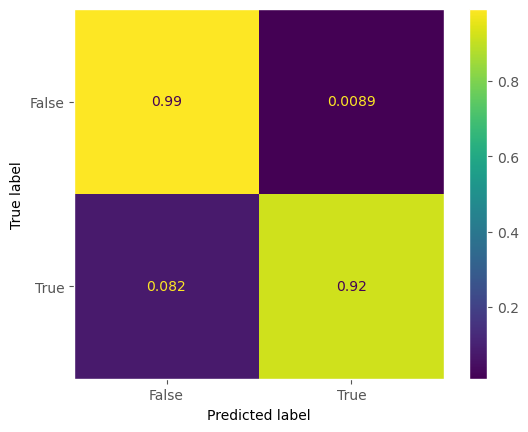

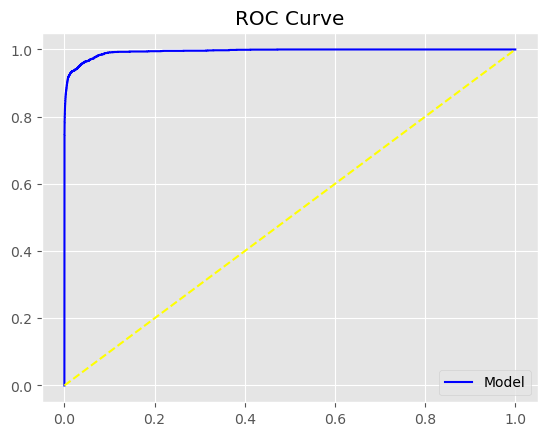

Accuracy 0.99
Precision: 0.29
Recall: 0.92
F1 Score 0.44
AUC: 0.9942959984638242


In [68]:
evaluate_model(y_test, y_pred_test, y_score_test, normalize_matrix="true")

# Hyperparameter Tuning

In [69]:
def tune_lgbm(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    mdl = LGBMClassifier(learning_rate= learning_rate,
                         num_leaves= num_leaves,
                         min_child_samples= min_child_samples,
                         subsample= subsample,
                         colsample_bytree= colsample_bytree,
                         random_state=23, subsample_freq=1,
                         n_estimators=200)
    
    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_valid)
    
    return -metrics.f1_score(y_valid, y_pred)

In [70]:
space = [(1e-3, 1e-1, "log-uniform"), #learning_rate
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05, 1.0), #subsample
        (0.1, 1.0)] #colsample_bytree

In [71]:
results = gp_minimize(tune_lgbm, space, random_state=23,
                      verbose=1, n_calls=100, n_random_starts=20)


Iteration No: 1 started. Evaluating function at random point.
[0.021786840314037433, 25, 78, 0.5952129636704409, 0.4977223159193984]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4225
Function value obtained: -0.9074
Current minimum: -0.9074
Iteration No: 2 started. Evaluating function at random point.
[0.002333405878539521, 15, 23, 0.8416721432755412, 0.4840888306663812]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wis

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3200
Function value obtained: -0.8821
Current minimum: -0.9447
Iteration No: 12 started. Evaluating function at random point.
[0.03486657777966428, 100, 97, 0.44192276574439365, 0.8162320161324087]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.7416
Function value obtained: -0.9455
Current minimum: -0.9455
Iteration No: 13 started. Eval

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.9155
Function value obtained: -0.5497
Current minimum: -0.9494
Iteration No: 23 started. Searching for the next optimal point.
[0.026032156616942175, 119, 96, 0.602573959291001, 0.893475575352263]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.1405
Function value obtained: -0.9411
Current minimum: -0.9494
Iteration

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.2044
Function value obtained: -0.9428
Current minimum: -0.9494
Iteration No: 34 started. Searching for the next optimal point.
[0.04858792358820441, 128, 100, 1.0, 0.1]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.2510
Function value obtained: -0.9434
Current minimum: -0.9494
Iteration No: 38 started. Searching for the next optimal point.
[0.040767065844179426, 2, 1, 1.0, 1.0]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.6882
Function value obtained: -0.7988
Current minimum: -0.9494
Iteration No: 39 started. Searching for the next op

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.0116
Function value obtained: -0.8503
Current minimum: -0.9515
Iteration No: 45 started. Searching for the next optimal point.
[0.010980284163456106, 128, 1, 0.9376956218949188, 0.9527588715151766]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.3310
Function value obtained: -0.9433
Current minimum: -0.9515
Iteration No: 46 started. Searching for the next optimal point.
[0.0390502407308413

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.3629
Function value obtained: -0.9114
Current minimum: -0.9521
Iteration No: 53 started. Searching for the next optimal point.
[0.03493918766978636, 128, 100, 1.0, 0.7924116552794419]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.2267
Function value obtained: -0.9457
Current minimum: -0.9521
Iteration No: 54 started. Searching for the next optimal point.
[0.1, 128, 100, 1.0, 0.1]
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 1.1403
Function value obtained: -0.8323
Current minimum: -0.9527
Iteration No: 57 started. Searching for the next optimal point.
[0.009455998154235569, 85, 1, 0.7375759454700088, 0.8164772002442859]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.2876
Function value obtained: -0.9321
Current minimum: -0.9527
Iteration No: 58 started. Searching for the next optimal point.
[0.01539068674888781

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.4670
Function value obtained: -0.9474
Current minimum: -0.9527
Iteration No: 65 started. Searching for the next optimal point.
[0.0199090784117765, 67, 1, 0.6240523705400028, 0.7085467129801983]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.4142
Function value obtained: -0.9405
Current minimum: -0.9527
Iteration No: 66 started. Searching for the next optimal point.
[0.005790185492548047,

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.0687
Function value obtained: -0.0000
Current minimum: -0.9527
Iteration No: 76 started. Searching for the next optimal point.
[0.060626910290205, 63, 100, 0.7901780238442527, 0.42372756848142634]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.3619
Function value obtained: -0.9248
Current minimum: -0.9527
Iteration No: 77 sta

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.6842
Function value obtained: -0.9474
Current minimum: -0.9527
Iteration No: 87 started. Searching for the next optimal point.
[0.031936404245050176, 2, 100, 0.05, 0.40493935623696]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.1878
Function value obtained: -0.8016
Current minimum: -0.9527
Iteration No: 88 started. Searching

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.7097
Function value obtained: -0.9494
Current minimum: -0.9545
Iteration No: 98 started. Searching for the next optimal point.
[0.1, 68, 1, 1.0, 0.7684481193541522]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.7214
Function value obtained: -0.9474
Current minimum: -0.9545
Iteration No: 99 started. Searching for the next optimal point.
[0.0711251056301497, 128, 1, 1.0, 0.5834436276733681

In [72]:
params = results.x
params

[0.03738471929067579, 76, 100, 1.0, 1.0]

In [73]:
learning_rate = params[0]
num_leaves = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]

In [74]:
#LightGBM
lgbm = LGBMClassifier(learning_rate= learning_rate,
                      num_leaves= num_leaves,
                      min_child_samples= min_child_samples,
                      subsample= subsample,
                      colsample_bytree= colsample_bytree,
                      random_state=23, subsample_freq=1,
                      n_estimators=200)

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


[LightGBM] [Info] Number of positive: 6005, number of negative: 60047

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1388

[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535

[LightGBM] [Info] Start training from score -2.302535

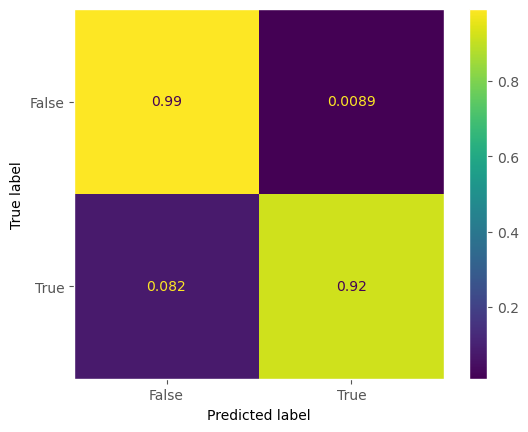

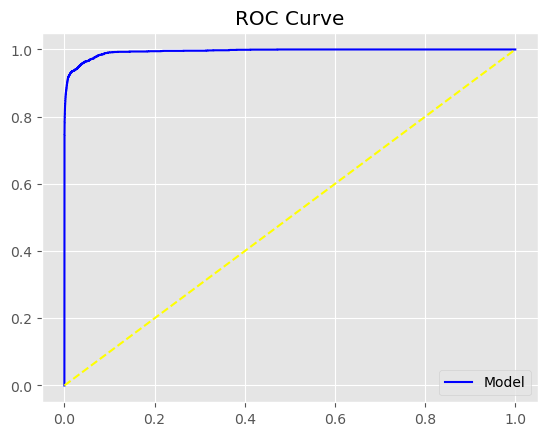

Accuracy 0.99
Precision: 0.29
Recall: 0.92
F1 Score 0.44
AUC: 0.9942959984638242


In [75]:
evaluate_model(y_test, y_pred_test, y_score_test, normalize_matrix="true")
